# Анализ игровой индустрии

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Открытие файла с данными и изучение общей информации

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns

In [ ]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [ ]:
df.isnull().sum().sort_values()

Platform              0
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Name                  2
Genre                 2
Year_of_Release     269
User_Score         6701
Rating             6766
Critic_Score       8578
dtype: int64

In [ ]:
round((df.isna().mean()*100).sort_values(), 2)

Platform            0.00
NA_sales            0.00
EU_sales            0.00
JP_sales            0.00
Other_sales         0.00
Name                0.01
Genre               0.01
Year_of_Release     1.61
User_Score         40.09
Rating             40.48
Critic_Score       51.32
dtype: float64

### Вывод

- Пропущенные значения:
 - самый большой процент пропусков (от 40% до 52%) в столбцах, отражащих информацию о рейтинге и оценке компьютерных игр критиками и пользователями (User_Score, Rating, Critic_Score).
 - почти 2% пропусков в столбце года выпуска игр (Year_of_Release).
 - по 2 значения пропусков (0.01%) в каждом из столбцов Name и Genre (нужно уточнить одни и те же ли это значения)
<br><br>
- Некорректный тип данных у следующих столбцов:
 - Year_of_Release - float64 надо заменить на int (плавающая запятая значению года выпуска не нужна)
 - User_Score - object на float64 (для оценки, выраженной числом, строчный тип данных заменим на вещественный)
 <br><br>
- Названия столбцов необходимо привести к нижнему регистру

## Предобработка данных

### Замена названия столбцов (приведение к нижнему регистру)

In [ ]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Cтолбец year_of_release

Преобразуем тип данных столбца year_of_release в целочисленный, а пропуски заменим на маркерное значение 9999.

In [ ]:
df['year_of_release'].fillna(9999 , inplace = True)
df['year_of_release'] = df['year_of_release'].astype('int')

### Cтолбцы name и genre 

In [ ]:
df.query('name.isnull() | genre.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Проверили, что пропуски в этих столбцах формируют одни и те же строки. Процент пропуска в этих столбцах меньше 1%. Удалим их.

In [ ]:
df.dropna(subset = ['name'], inplace = True)

### Cтолбец user_score  

In [ ]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Просмотрев столбец user_score на уникальные значения, видим, что помимо nan, он содержит в себе значения типа tbd. TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). В данном конкретном случае, такие значения означают, что рейтинг пока еще не определен. Заменим tbd на NaN.

In [ ]:
df['user_score'].replace('tbd', np.NaN, inplace = True)

In [ ]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [ ]:
df['user_score'] = df['user_score'].astype('float')

Перевели тип данных из типа object в тип float, пропуски оставим.

### Cтолбцы rating и critic_score 

In [ ]:
round((df.isna().mean()*100).sort_values(), 2)

name                0.00
platform            0.00
year_of_release     0.00
genre               0.00
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
rating             40.47
critic_score       51.31
user_score         54.59
dtype: float64

In [ ]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Просмотрев столбец rating на уникальные значения, видим, что он содержит в себе значения nan. Скорее всего это те значения рейтинга, которые еще не были определены ESRB, также как TBD значения в столбце user_score.

In [ ]:
df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Пропуски в столбце critic_score оставим, так как их обработка может исказить статистику.

In [ ]:
df['rating'].fillna('unknown', inplace = True)

Пропуски в столбце rating заменим маркерным значением unknown.

### Расчет суммарных продаж во всех регионах

In [ ]:
df['global_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Вывод

- Названия столбцов были приведены к нижнему регистру
- Пропуски в столбцах name и genre были проверены, и 2 эти записи были удалены
- Пропуски в столбце year_of_release были заполнены маркерным значениям, а тип данных значений этого столбца переведен в целочисленный формат
- Значения типа "TBD" в столбце user_score заменили в соответствии со смыслом этой аббревиатуры на NaN, тип данных значений этого столбца перевели из типа object в тип float
- Пропуски в столбце rating заменили маркерным значением unknown.
- Пропуски в столбцах user_score и critic_score оставили, чтобы их заполнение не повлияло на статистические данные
- Посчитали общие продажи по всем регионам в столбце global_sales

## Исследовательский анализ данных

### Анализ количества выпущенных игр в разные годы

Text(0, 0.5, 'Количество игр, ед.')

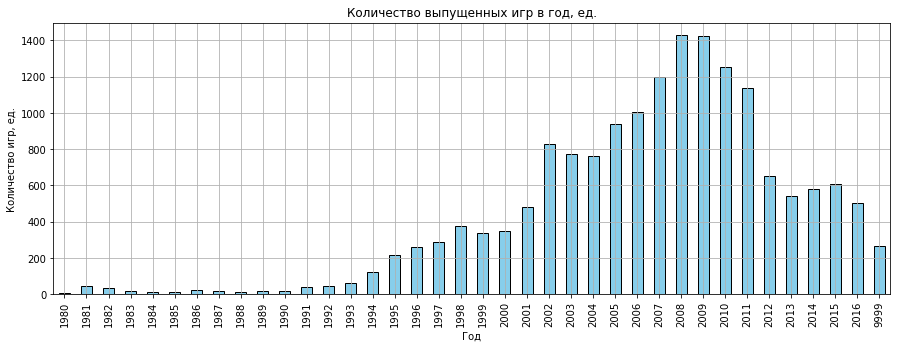

In [ ]:
df.groupby('year_of_release')['name'].count().plot(kind='bar', ec='black', figsize=(15,5), grid = True, color='#87CEEB', title = 'Количество выпущенных игр в год, ед.')
plt.xlabel("Год")
plt.ylabel("Количество игр, ед.")

In [ ]:
df.groupby('year_of_release')['name'].count().head(100)

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
9999     269
Name: name, dtype: int64

Активный рост выпуска компьютерных игр начинается с 1994 года: еще в 1993 - 63 игры в год, в 1994 - уже 121.<br>
Следующий скачок происходит в 2002 году: в 2001 - 482 игры в год, в 2002 - 829.<br>
Пик выпуска компьютерных игр приходится на 2008-2009 гг: 1427 и 1426 игр в год соответственно.<br>
После 2009г г. количество выпущенных игр в год снижается каждый год.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [ ]:
platform_sales = df.groupby('platform')['global_sales'].sum().sort_values(ascending = False)
platform_sales

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
3DS      259.00
XB       257.74
GB       255.46
NES      251.05
N64      218.68
SNES     200.04
GC       198.93
XOne     159.32
2600      96.98
WiiU      82.19
PSV       54.07
SAT       33.59
GEN       28.35
DC        15.95
SCD        1.86
NG         1.44
WS         1.42
TG16       0.16
3DO        0.10
GG         0.04
PCFX       0.03
Name: global_sales, dtype: float64

Text(0, 0.5, 'Количество проданных копий игр, млн.')

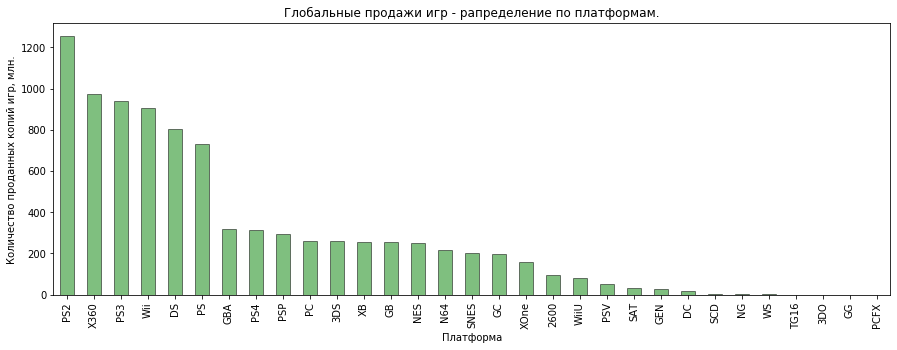

In [ ]:
plt.figure(figsize =(15, 5))
platform_sales.plot( kind='bar', alpha=0.5, figsize=(15,5), ec='black', color='green',title = 'Глобальные продажи игр - рапределение по платформам.')
plt.xlabel("Платформа")
plt.ylabel('Количество проданных копий игр, млн.')

Платформы с наибольшими суммарными продажами: PS2, X360, PS3, Wii, DS и PS.

In [ ]:
platform_top_sales = platform_sales.head(6).reset_index()
platform_top_sales_list = platform_top_sales['platform'].unique()

In [ ]:
def bar_plot_platform_global_sales(platform):
    x1 = df[df['platform'] == p].groupby('year_of_release')['global_sales'].sum()
    
    plt.figure(figsize =(15, 5))
    hist = x1.plot(
                kind='bar', 
                alpha=0.5, 
                ec='black',
                color='green',
                )
    plt.title('Суммарные продажи по годам по платформе ' + p)
    plt.xlabel('Год')
    plt.ylabel('Количество проданных копий игр, млн.')
    plt.grid()
    plt.show()

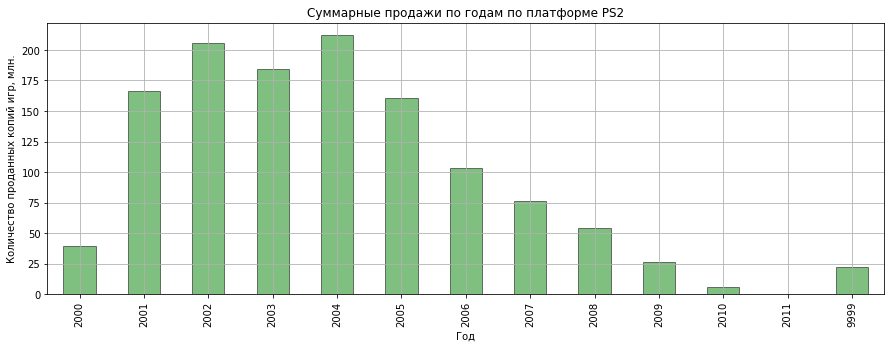

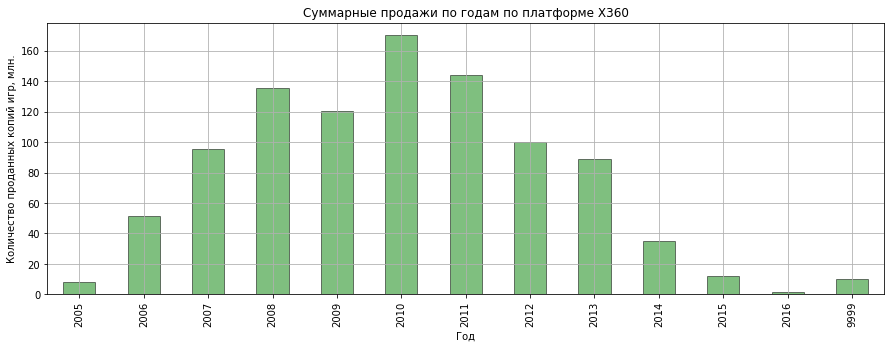

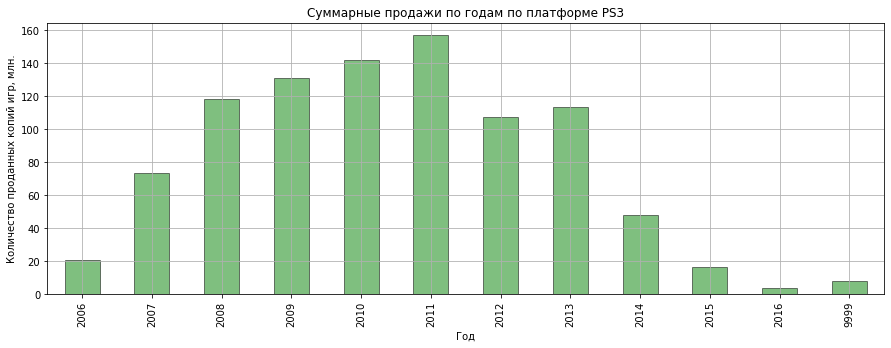

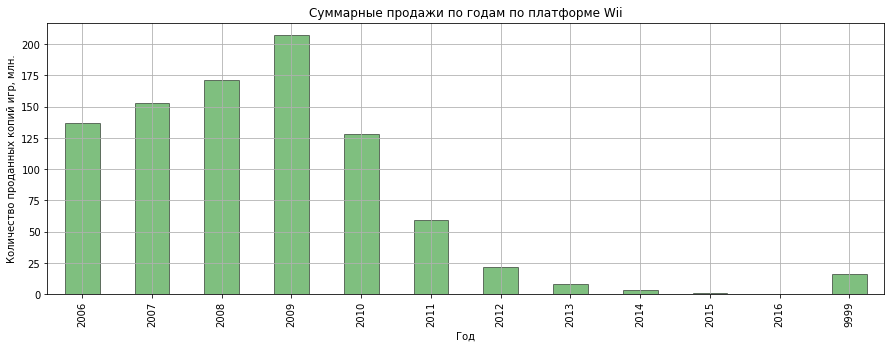

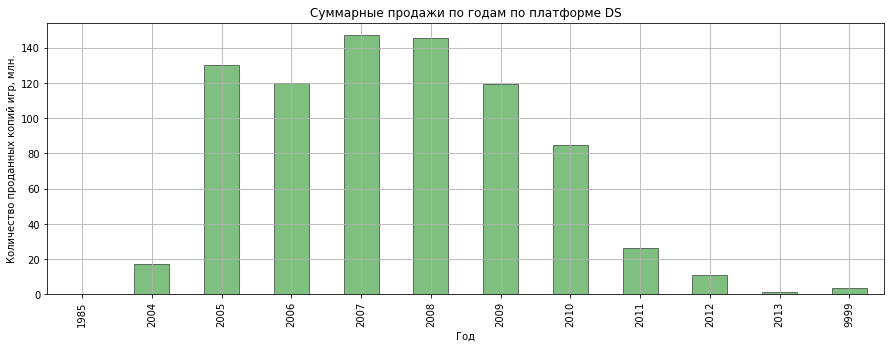

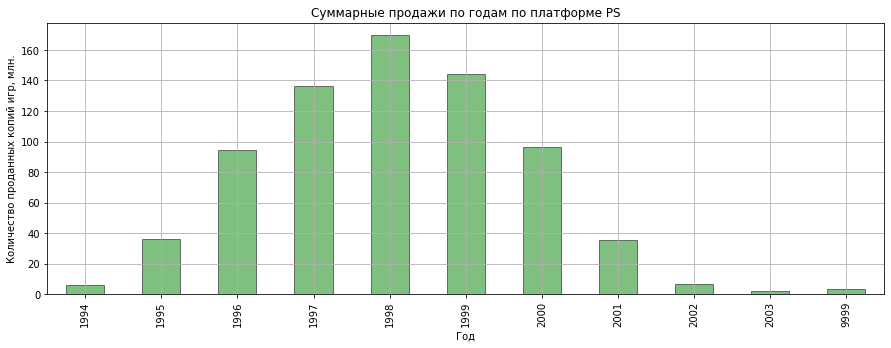

In [ ]:
for p in platform_top_sales_list:
    bar_plot_platform_global_sales(p)

В среднем игровые платформы существуют по 10 лет, пик продаж наступает в среднем наступают спустя 4 года после выхода платформы на рынок:
 - PS2 с 2000 по 2010 (10 лет), пик продаж - 2004 год, спустя 4 года
 - X360 с 2005 по 2015 (10 лет), пик продаж - 2010 год, спустя 5 лет
 - PS3 с 2006 по 2016 (10 лет), пик продаж - 2011 год, спустя 5 лет
 - Wii с 2006 по 2015 (9 лет), пик продаж - 2009 год, спустя 3 года
 - DS с 2004 по 2013 (9 лет), пик продаж - 2007 и 2008 год, спустя 3 года
 - PS с 1994 по 2003 год (9 лет), пик продаж - 1998 год, спустя 4 года

В шестерку платформ с наибольшими суммарными продажам входят несколько поколений PS, если сравнить их суммарные продажи, можно сделать вывод о том, что каждое новое поколение платформы выходит появляется каждые 6 лет (PS (1994)- PS2 (2000) - PS3 (2006)).

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.

Если актуальный период определять, основываясь на среднем сроке жизни платформы, в него попадут платформы, которые никак не влияют на актуальные продажи, что может исказить дальнейший анализ. Таким образом, актуальный период определим, ориентируясь на средний пик продаж или средний пик жизни платформы <b>(4 года)</b>, с 2013 года (отсчитывая с 2017).

In [ ]:
df_new = df[df['year_of_release'] >= 2013]
df_new.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,global_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [ ]:
df_new_filtered = df_new.pivot_table(
    index='year_of_release', columns='platform', values=['global_sales'], fill_value=0)
df_new_filtered

global_sales                                                \
platform                2600       3DS        DS    GB       GBA        GC   
year_of_release                                                              
2013                0.000000  0.621648  0.192500  0.00  0.000000  0.000000   
2014                0.000000  0.547000  0.000000  0.00  0.000000  0.000000   
2015                0.000000  0.323023  0.000000  0.00  0.000000  0.000000   
2016                0.000000  0.329130  0.000000  0.00  0.000000  0.000000   
9999                0.617647  0.148750  0.111333  1.03  0.451818  0.157143   

                                                                             \
platform              N64        PC        PS       PS2       PS3       PS4   
year_of_release                                                               
2013             0.000000  0.325789  0.000000  0.000000  0.898810  1.624375   
2014             0.000000  0.282553  0.000000  0.000000  0.442222  1.333333   
2015             0.000000  0.170400  0.000000  0.000000  0.230411  0.867883   
2016             0.000000  0.097222  0.000000  0.000000  0.094737  0.422256   
9999             0.223333  0.221176  0.468571  0.653235  0.332400  0.000000   

                                                                            \
platform              PSP       PSV       Wii      WiiU      X360       XB   
year_of_release                                                              
2013             0.058148  0.168095  0.715833  0.515476  1.181067  0.00000   
2014             0.024000  0.119000  0.625000  0.710645  0.551429  0.00000   
2015             0.040000  0.056818  0.285000  0.583929  0.341714  0.00000   
2016             0.000000  0.050000  0.180000  0.328571  0.116923  0.00000   
9999             0.282500  0.260000  0.480294  0.000000  0.339333  0.29381   

                           
platform             XOne  
year_of_release            
2013             0.997895  
2014             0.886393  
2015             0.751750  
2016             0.300575  
9999             0.000000

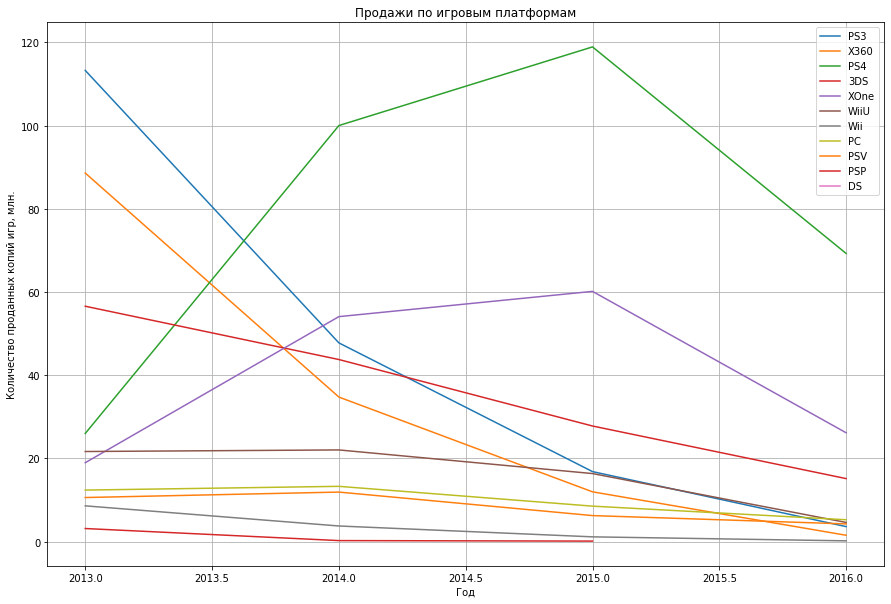

In [ ]:
plt.figure(figsize=(15,10))
plt.title('Продажи по игровым платформам')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий игр, млн.')
plt.grid()

for p in df_new['platform'].unique():
    sns.lineplot(data = df_new[(df_new['platform'] == p) & (df_new['year_of_release'] <= 2016)].groupby('year_of_release')['global_sales'].sum(), label=p)
    plt.legend()

In [ ]:
df_new_filtered_2016 = df_new[df_new['year_of_release'] == 2016].pivot_table(
    index='year_of_release', columns='platform', values=['global_sales'], fill_value=0)
df_new_filtered_2016

global_sales                                            \
platform                 3DS        PC       PS3       PS4   PSV   Wii   
year_of_release                                                          
2016                 0.32913  0.097222  0.094737  0.422256  0.05  0.18   

                                               
platform             WiiU      X360      XOne  
year_of_release                                
2016             0.328571  0.116923  0.300575

К 2016 году продажи игр по всем платформам падают.<br>
- Самые прибыльные платформы на конец 2016 года, в порядке убывания продаж:
 - PS4
 - XOne
 - 3DS<br>
- На окончание 2016 года продажи по всем остальным платформам, распределяются так:
 - 4 и 5 место соответственно занимают PC и PS3, продажи игр на этих платформах практически равны
 - 6 место WiiU
 - 7 и 8 место занимают Wii и X360, продажи практически равны
 - 9 место и минимальные продажи у платформы PSV

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

Text(0, 0.5, 'Количество проданных копий игр, млн.')

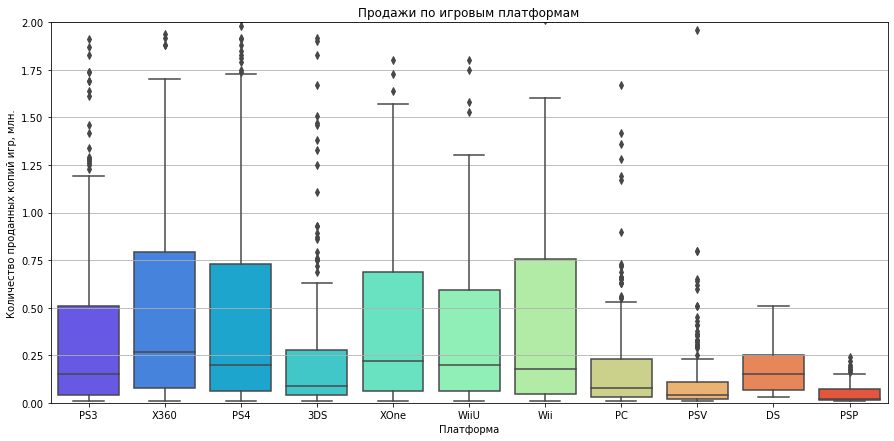

In [ ]:
plt.figure(figsize=(15,7))
plt.title('Продажи по игровым платформам')
plt.grid()
plt.ylim(0, 2)
sns.boxplot(x="platform", y="global_sales", data=df_new[(df_new['year_of_release'] <= 2016)], palette='rainbow')
plt.xlabel('Платформа')
plt.ylabel('Количество проданных копий игр, млн.')

- Наибольшие медианные значения продаж у консоли X360
- Самые успешные платформы по продажам, чьи медианные продажи близки к лидеру X360, это - XOne, PS4, Wii, WiiU
- Наименьшие из медианных продаж среди крупных консолей у PS3
- Наименьшие медианные продажи среди всех платформ у портативных консолей - 3DS, PSV, DS и PSP, а также у игр на персональных компьютерах.

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы. Соотнесите выводы с продажами игр на других платформах.

В качестве популярной платформы для анализа возьмем PS4, которая на 2016 год является самой прибыльной игровой платформой. В качестве альтернативных игровых платформ возьмем XOne и персональный компьютер (PC).

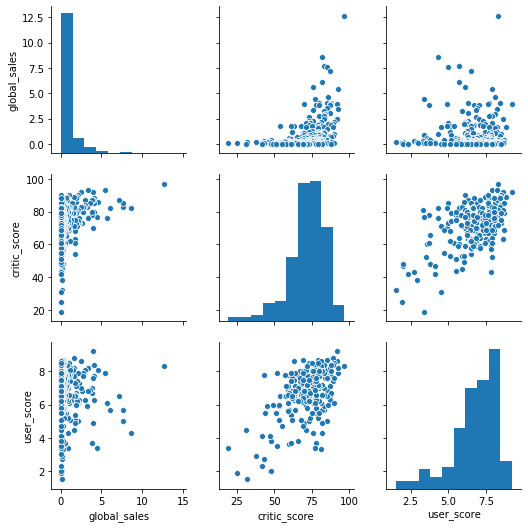

In [ ]:
sns.pairplot(df_new[df_new['platform'] == 'PS4'][['global_sales', 'critic_score', 'user_score']])
plt.show()

In [ ]:
df_new[df_new['platform'] == 'PS4'][['global_sales', 'critic_score', 'user_score']].corr()

,global_sales,critic_score,user_score
global_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


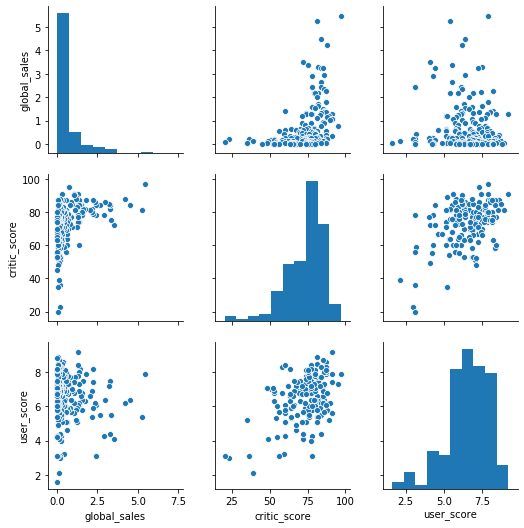

In [ ]:
sns.pairplot(df_new[df_new['platform'] == 'XOne'][['global_sales', 'critic_score', 'user_score']])
plt.show()

In [ ]:
df_new[df_new['platform'] == 'XOne'][['global_sales', 'critic_score', 'user_score']].corr()

,global_sales,critic_score,user_score
global_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


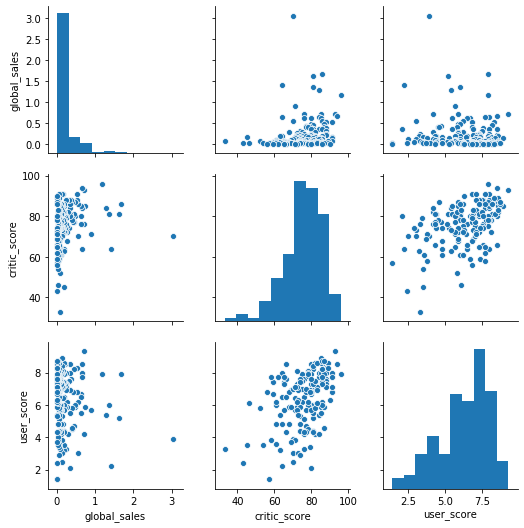

In [ ]:
sns.pairplot(df_new[df_new['platform'] == 'PC'][['global_sales', 'critic_score', 'user_score']])
plt.show()

In [ ]:
df_new[df_new['platform'] == 'PC'][['global_sales', 'critic_score', 'user_score']].corr()

,global_sales,critic_score,user_score
global_sales,1.000000,0.201574,-0.101695
critic_score,0.201574,1.000000,0.450575
user_score,-0.101695,0.450575,1.000000


Сравнив самую популярную на 2016 год платформу, ее главного конкурента среди консолей, а также игры на персональных компьютерах получаем такие выводы:
- В сравнении по всем платформам корреляции по параметрам не сильно отличаются
- Сильнее на продажи влияет оценка критиков - чем больше положительных отзывов, тем лучше продажи. Наименьшее влияние оценки критиков наблюдаем на продажи игр на платформе PC.
- Связь между оценками пользователей и продажами слабая у всех платформ, покупатели при покупке больше прислушиваются к отзывам критиков.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

<div style="background: #c88ea4;color: #fff;padding: 10px;border-radius: 5px;opacity: 0.8"> 
Добавила новый столбцец в сводну таблицу - показатель прибыльности одной игры каждого жанра, для этого разделили глобальные продажи на количество выпущенных игр.</div>

In [ ]:
genres = df_new.pivot_table(index = ['genre'],
                            values = ['global_sales', 'name'],
                            aggfunc = {'global_sales': 'sum' ,
                                       'name': 'count'}).sort_values(by='global_sales', ascending=False)
genres['one_game_sales'] = genres['global_sales'] / genres['name']
genres.sort_values(by='one_game_sales', ascending=False)

,global_sales,name,one_game_sales
genre,,,
Shooter,244.07,214,1.140514
Sports,172.25,256,0.672852
Platform,44.85,84,0.533929
Role-Playing,149.37,309,0.483398
Fighting,40.18,92,0.436739
Action,349.52,828,0.422126
Racing,45.07,108,0.417315
Misc,75.04,184,0.407826
Simulation,23.77,78,0.304744


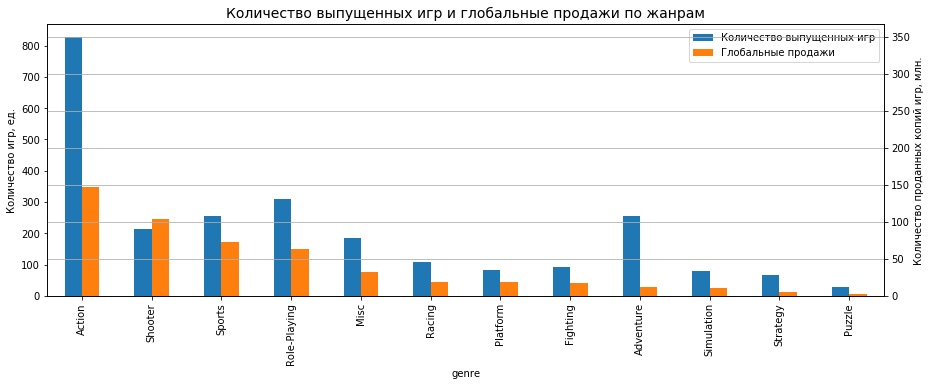

In [ ]:
x = genres[['name', 'global_sales']].plot(kind='bar', figsize=(15, 5))
plt.title('Количество выпущенных игр и глобальные продажи по жанрам', fontsize=14)
plt.ylabel('Количество игр, ед.')
plt.xlabel('Жанр')
plt.legend(['Количество выпущенных игр', 'Глобальные продажи'])

genres[['global_sales']].plot(kind='bar', ax = x, alpha = 0.0, legend=False, secondary_y=True)
plt.ylabel('Количество проданных копий игр, млн.')
plt.grid()

Text(0.5, 0, 'Жанр')

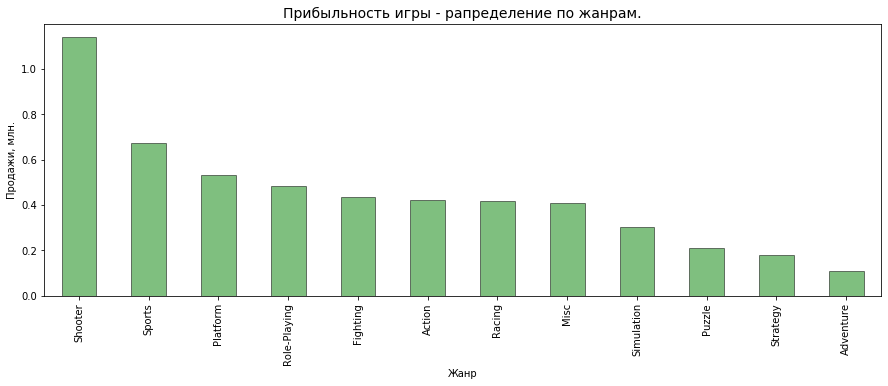

In [ ]:
genres['one_game_sales'].sort_values(ascending=False).plot(kind='bar', figsize=(15, 5), alpha=0.5, ec='black', color='green',)
plt.title('Прибыльность игры - рапределение по жанрам.', fontsize=14)
plt.ylabel('Продажи, млн.')
plt.xlabel('Жанр')

Проанализировав оба графика, сделаем следующие выводы:
- Лидеры глобальных продаж - игры жанра Action, на втором и третьем месте по глобальным продажам игры жанра Shooter и Sports соответственно.
- Самый прибыльный жанр (в расчете продаж на одну игру) - Shooter. Следом за ним - игры жанра Sports и Platform. Игры этих жанров смогут принести большую прибыль при гораздо меньшем количестве проданных копий по сравнению с остальными жанрами. 
- Самые неперспективные жанры - Adventure, Strategy и Puzzle.

### Вывод

- Активный рост выпуска компьютерных игр начинается с 1994 года. На 2008-2009 год приходится пик выпуска компьютерных игр, после этого происходит резкий спад.
- В среднем игровые платформы существуют 10 лет, пик продаж наступает спустя 4 года поле выхода платформы на рынок. Самые популярные игровые платформы за весь период - Sony PlayStation 2, Xbox 360, Sony Playstation 3, Nintendo WII, Nintendo DS, Sony Playstation.
- Самые популярные платформы на конец 2016 года - Sony PlayStation 4, Xbox One, Nintendo 3DS.
- Наибольшие медианные значения продаж у консоли X360
- Компьютерные игры продаются хуже, чем консольные.
- На продажи по всем платформам сильнее влияет оценка критиков - чем больше положительных отзывов, тем лучше продажи, связь между оценками пользователей и продажами слабее. При покупке больше прислушиваются к мнению критиков.
- Самый прибыльный жанр - Shooter. Следом за ним - игры жанра Sports и Platform. Игры этих жанров смогут принести большую прибыль при гораздо меньшем количестве проданных копий по сравнению с остальными жанрами.

## Составление портрета пользователя каждого региона

Напишем функцию, которая для каждого из 3 регионов выведет сводные таблицы по указанному параметру, а также графики распределения.

In [ ]:
def top_5_parametr(p, ttl):
    
    if p == 'platform':
        xlabel = 'Платформа'
    elif p == 'genre':
        xlabel = 'Жанр'
    else:
        xlabel = 'Рейтинг'
    
    ylabel = 'Продажи, млн. копий'

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    for region, ax in zip(list(['na_sales','eu_sales','jp_sales']),(ax1, ax2, ax3)):
        
        df_filter = df_new.pivot_table(index=p, values=region, aggfunc='sum').sort_values(by=region, ascending=False).reset_index().rename_axis(None, axis=1).head(5)
        print(df_filter)
        print('\n\n')
        
        if region == 'na_sales':
            title = 'Северная Америка'
        elif region == 'eu_sales':
            title = 'Европа'
        else:
            title = 'Япония'
            
        sns.barplot(data=df_filter, x=p, y=region, ax=ax).set(title=title, xlabel= xlabel, ylabel=ylabel)
        fig.suptitle(ttl, fontsize=15)

### Самые популярные платформы (топ-5) для каждого региона

  platform  na_sales
0      PS4    108.74
1     XOne     93.12
2     X360     88.39
3      PS3     66.86
4      3DS     39.04



  platform  eu_sales
0      PS4    141.09
1      PS3     70.89
2     XOne     51.59
3     X360     44.96
4      3DS     31.17



  platform  jp_sales
0      3DS     67.86
1      PS3     24.13
2      PSV     18.66
3      PS4     15.96
4     WiiU     10.88





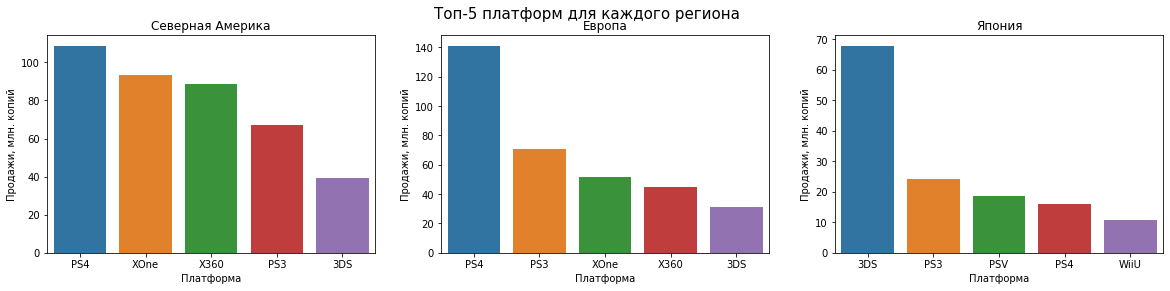

In [ ]:
top_5_parametr('platform', 'Топ-5 платформ для каждого региона')

- И в  Северной Америке, и в Европе лидирующие позиции занимает PlayStation 4.
- В Северной Америке после PlayStation 4 предпочтение отдают Xbox, а конкретно Xbox One и Xbox 360.
- В Европе предпочитают PlayStation, первые позиции - PlayStation 4 и PlayStation 3, вслед за ними Xbox One и Xbox 360.
- Самая популярная портативная консоль, и в Северной Америке, и в Европе, - Nintendo 3DS.
- Рынок портативных консолей наиболее развит в Японии. Самая популярная игровая платформа - портативная консоль Nintendo 3DS, также в топ-5 попадает портативная Playstation Vita. Из обычных консолей самые популярные за актуальный период - PlayStation 3, PlayStation 4 и WiiU.

### Самые популярные жанры (топ-5) для каждого региона

          genre  na_sales
0        Action    141.89
1       Shooter    117.15
2        Sports     78.50
3  Role-Playing     47.17
4          Misc     35.19



          genre  eu_sales
0        Action    126.27
1       Shooter     90.68
2        Sports     65.98
3  Role-Playing     37.44
4        Racing     22.21



          genre  jp_sales
0  Role-Playing     53.06
1        Action     41.78
2          Misc     10.29
3      Fighting      7.85
4       Shooter      6.69





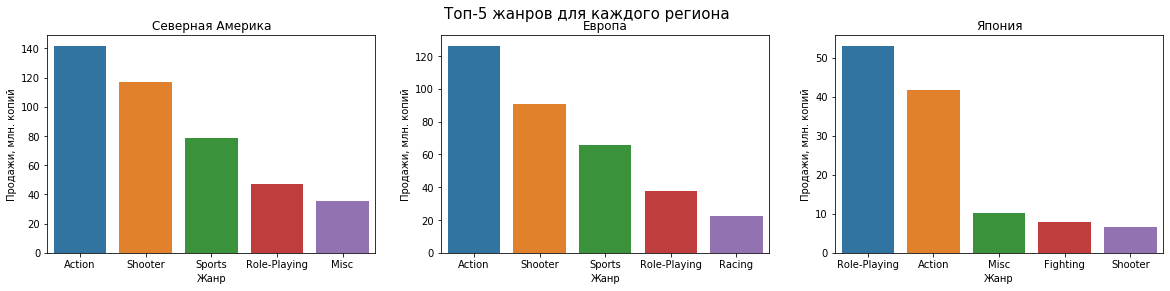

In [ ]:
top_5_parametr('genre', 'Топ-5 жанров для каждого региона')

- В Северной Америке и Европе топ жанры практически совпадают, отличается лишь пятое место в топе.
- В Японии предпочтения отличаются - на первом месте игры жанра Role-Playing, жанр Shooter на последнем месте в топе, жанра Sports вообще нет, зато на замену ему пришел жанр Fighting.

### Влияние рейтинга ESRB на продажи в каждом отдельном регионе

    rating  na_sales
0        M    170.80
1  unknown    104.26
2        E     97.80
3     E10+     62.06
4        T     61.94



    rating  eu_sales
0        M    149.29
1        E     89.74
2  unknown     82.56
3     E10+     47.86
4        T     47.19



    rating  jp_sales
0  unknown     90.24
1        T     21.29
2        E     15.29
3        M     14.77
4     E10+      5.89





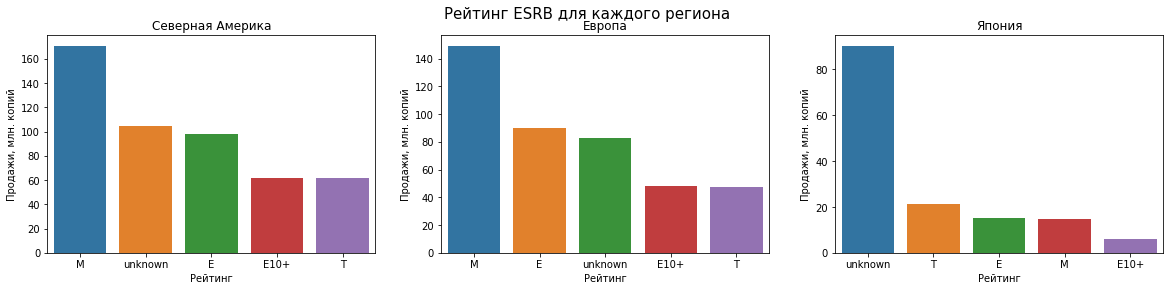

In [ ]:
top_5_parametr('rating', 'Рейтинг ESRB для каждого региона')

- В Северной Америке и Европе наиболее продаваемые игры рейтинга «M» - «Для взрослых» и игры рейтинга «E» - «Для всех», следом за ними идут игры для детей E10+ - «Для всех от 10 лет и старше» и для подростков T» - «Подросткам»
- В Японии самые продаваемые игры рейтинга T» - «Подросткам», а только потом игры «Для взрослых» и «Для всех»

### Вывод

Японский игровой рынок очень отличается от игрового рынка Северной Америки и Европы:
- И в  Северной Америке, и в Европе лидирующие позиции среди всех игровых платформ занимает PlayStation 4.
- В Японии преобладают портативные консоли, в Северной Америке и Европе - обычные консоли, причем в Америке - Xbox, а в Европе - Playstation.
- Преобладающие жанры в Северной Америке и Европе похожи - это Action, Shooter и Sports, в Японии же самый популярный жанр - жанр Role-Playing, жанра Shooter в топе вообще нет, зато есть жанр Fighting
- Игры рейтинга «M» («Для взрослых») - самый продаваемые для Северной Америки и Европы, следом идут игры «E» - «Для всех», а в Японии преобладают игры рейтинг T»(«Подросткам»), а только потом игры «Для взрослых» и «Для всех».

## Проверка гипотез

### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Нулевая гипотеза:  Средние пользовательские рейтинги платформ «Xbox One и PC равны. <br>
Альтернативная гипотеза: Средние пользовательские рейтинги платформ «Xbox One и PC различаются.

In [ ]:
df_new[(df_new['platform'] == 'XOne') | (df_new['platform'] == 'PC')].groupby('platform').agg({'user_score': ['count', 'mean', 'median', np.std, np.var]})

user_score                                     
              count      mean median       std       var
platform                                                
PC              170  6.324118    6.8  1.721791  2.964563
XOne            182  6.521429    6.8  1.380941  1.906997

In [ ]:
df_new_xone = df_new[df_new['platform'] == 'XOne']['user_score'].dropna()
df_new_pc = df_new[df_new['platform'] == 'PC']['user_score'].dropna()

Text(0, 0.5, 'Частота')

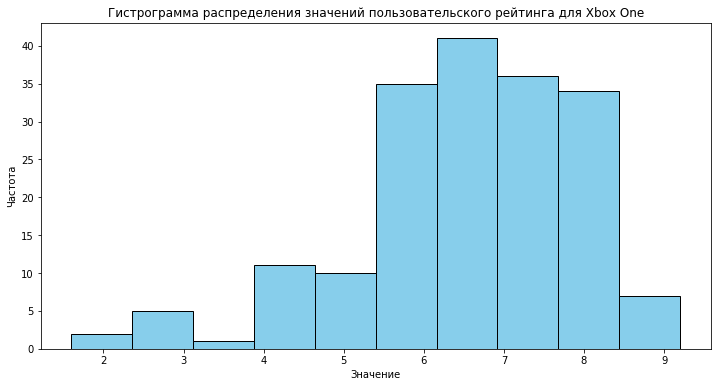

In [ ]:
df_new_xone.plot(kind='hist', bins= 10, figsize=(12,6), ec='black', color='#87CEEB',
                 title = 'Гистрограмма распределения значений пользовательского рейтинга для Xbox One')
plt.xlabel('Значение')
plt.ylabel('Частота')

Text(0, 0.5, 'Частота')

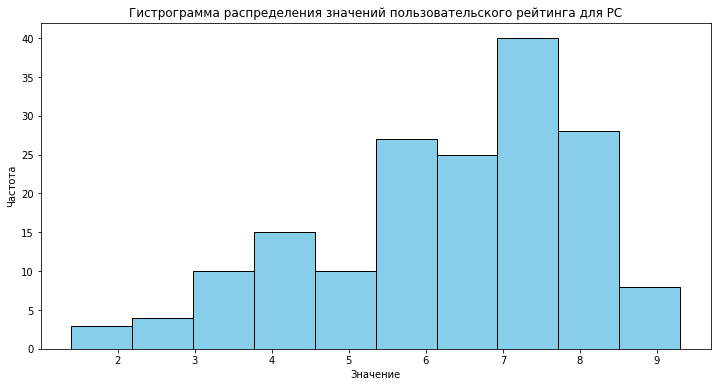

In [ ]:
df_new_pc.plot(kind='hist', bins= 10, figsize=(12,6), ec='black', color='#87CEEB',
               title = 'Гистрограмма распределения значений пользовательского рейтинга для PC')
plt.xlabel('Значение')
plt.ylabel('Частота')

- Для тестирования гипотез будем использовать Т-критерий Стьюдента, так как:
    - проанализировав графики и сводные таблицы, видим, что данные распределяются по закону нормального распределения
    - 2 независимые выборки (разные игровые платформы)
    - сравниваем средние 2 генеральных совокупностей

- Критерий значимости или уровень достоверности определим как 0,05 (5%). Таким образом при проверке статистических гипотез вероятность совершить ошибку первого рода, то есть отвергнуть истинную нулевую гипотезу, будет равна 5%.

In [ ]:
alpha = 0.05

results = st.ttest_ind(df_new_xone, df_new_pc)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.23496453086902092
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу не получилось отвергнуть. Имеющиеся данные ей не противоречат.

### Гипотеза 2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза:  Средние пользовательские рейтинги жанров Action и Sports равны. <br>
Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [ ]:
df_new[(df_new['genre'] == 'Action') | (df_new['genre'] == 'Sports')].groupby('genre').agg({'user_score': ['count', 'mean', 'median', np.std, np.var]})

user_score                                     
            count      mean median       std       var
genre                                                 
Action        423  6.837589   7.10  1.343417  1.804769
Sports        182  5.504396   5.75  1.855046  3.441196

Text(0, 0.5, 'Частота')

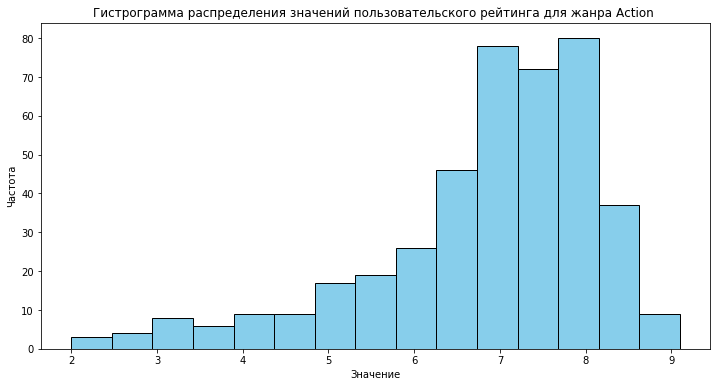

In [ ]:
df_new[(df_new['genre'] == 'Action')]['user_score'].dropna().plot(kind='hist', bins= 15, figsize=(12,6), ec='black', color='#87CEEB',
                                                         title = 'Гистрограмма распределения значений пользовательского рейтинга для жанра Action ')
plt.xlabel('Значение')
plt.ylabel('Частота')

Text(0, 0.5, 'Частота')

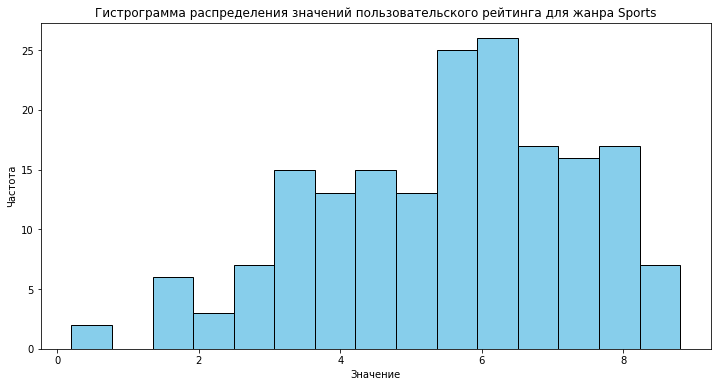

In [ ]:
df_new[(df_new['genre'] == 'Sports')]['user_score'].dropna().plot(kind='hist', bins= 15, figsize=(12,6), ec='black', color='#87CEEB',
                                                         title = 'Гистрограмма распределения значений пользовательского рейтинга для жанра Sports')
plt.xlabel('Значение')
plt.ylabel('Частота')

Для тестирования этих гипотез как и в прошлом тесте будем использовать Т-критерий Стьюдента и критерий значимости 0.05, так как все параметры похожи.

In [ ]:
df_new_action = df_new[df_new['genre'] == 'Action']['user_score'].dropna()
df_new_sports = df_new[df_new['genre'] == 'Sports']['user_score'].dropna()

alpha = 0.05

results = st.ttest_ind(df_new_action, df_new_sports, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.3672011662072006e-16
Отвергаем нулевую гипотезу


In [ ]:
df_new_action

16       8.2
23       8.1
42       8.3
149      9.1
165      7.9
        ... 
16597    6.0
16652    8.5
16654    5.1
16660    6.7
16692    7.6
Name: user_score, Length: 423, dtype: float64

Нулевая гипотеза отвергается. 

### Вывод

Проверили гипотезы с помощью Т-критерия Стьюдента:
- Нулевую гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC не получилось отвергуть. Данные ей не противоречат.
- Нулевая гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports отвергнута.

## Общий вывод

- Ознакомившись с данными, выявили наличие пропусков и несоответствие типов данных.
- Некоторые пропуски были заполнены, необычные значения "TBD" были заменены на NaN, в соответствии со смыслом этой аббревиатуры - To Be Determined (будет определено), некоторые пропуски были оставлены, чтобы не исказить дальнейший анализ.
- Общие продажи по всем регионам были посчитаны и записаны в столбец global_sales.
<br><br>
- Рост выпуска компьютерных игр начинается с 1994 года, резкий скачок происходит в 2002 году, пик приходится на 2008-2009 годы, после этого происходит спад продаж.
- Самые популярные игровые платформы за весь период - Sony PlayStation 2, Xbox 360, Sony Playstation 3, Nintendo WII, Nintendo DS, Sony Playstation.
- Самые популярные платформы на конец 2016 года - Sony PlayStation 4, Xbox One, Nintendo 3DS.
- В среднем игровые платформы существуют по 10 лет, пик продаж наступает спустя 4 года после выхода платформы на рынок.
- Компьютерные игры продаются хуже, чем консольные.
- Оценки критиков сильнее влияют на продажи компьютерных игр, чем оценки рядовых игроков.
- Самый прибыльные жанры - Shooter, Sports и Platform. Наименнее перспективные - Adventure, Strategy и Puzzle.
<br><br>
- Были составлены портреты пользователей каждого региона. 
- Японский игровой рынок очень отличается от игрового рынка Северной Америки и Европы:
- И в Северной Америке, и в Европе лидирующие позиции среди всех игровых платформ занимает PlayStation 4.
- В Японии преобладают портативные консоли, в Северной Америке и Европе - обычные консоли, причем в Америке - Xbox, а в Европе - Playstation.
- Преобладающие жанры в Северной Америке и Европе похожи - это Action, Shooter и Sports, в Японии же самый популярный жанр - жанр Role-Playing, жанра Shooter в топе вообще нет, зато есть жанр Fighting
- Игры рейтинга «M» («Для взрослых») - самый продаваемые для Северной Америки и Европы, следом идут игры «E» - «Для всех», а в Японии преобладают игры рейтинг T»(«Подросткам»), а только потом игры «Для взрослых» и «Для всех».
<br><br>
- Проверили гипотезы с помощью Т-критерия Стьюдента:
- Нулевую гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC не получилось отвергуть. Данные ей не противоречат.
- Нулевая гипотеза о равенстве средних пользовательских рейтингов жанров Action и Sports отвергнута.